## OpenStreetMap Data Case Study using MongoDB

### Map Area : Singapore
This dataset was chosen because this is the where I've called home for the last nine years. So it should be interesting to see how well maintained is the data in OSM for this country and if this analysis will be able to uncover any mistakes that is worth fixing.

Also I've just learn about how useful OpenStreetMap can be especially during crisis, such as the Haitian earthquake where the maps were used to map to new roads in the disaster area to map shortest routes towards help, drinking water, resources, etc. Thus it's definitely a good tool to learn.

1. https://www.openstreetmap.org/relation/536780
1. https://mapzen.com/data/metro-extracts/metro/singapore/

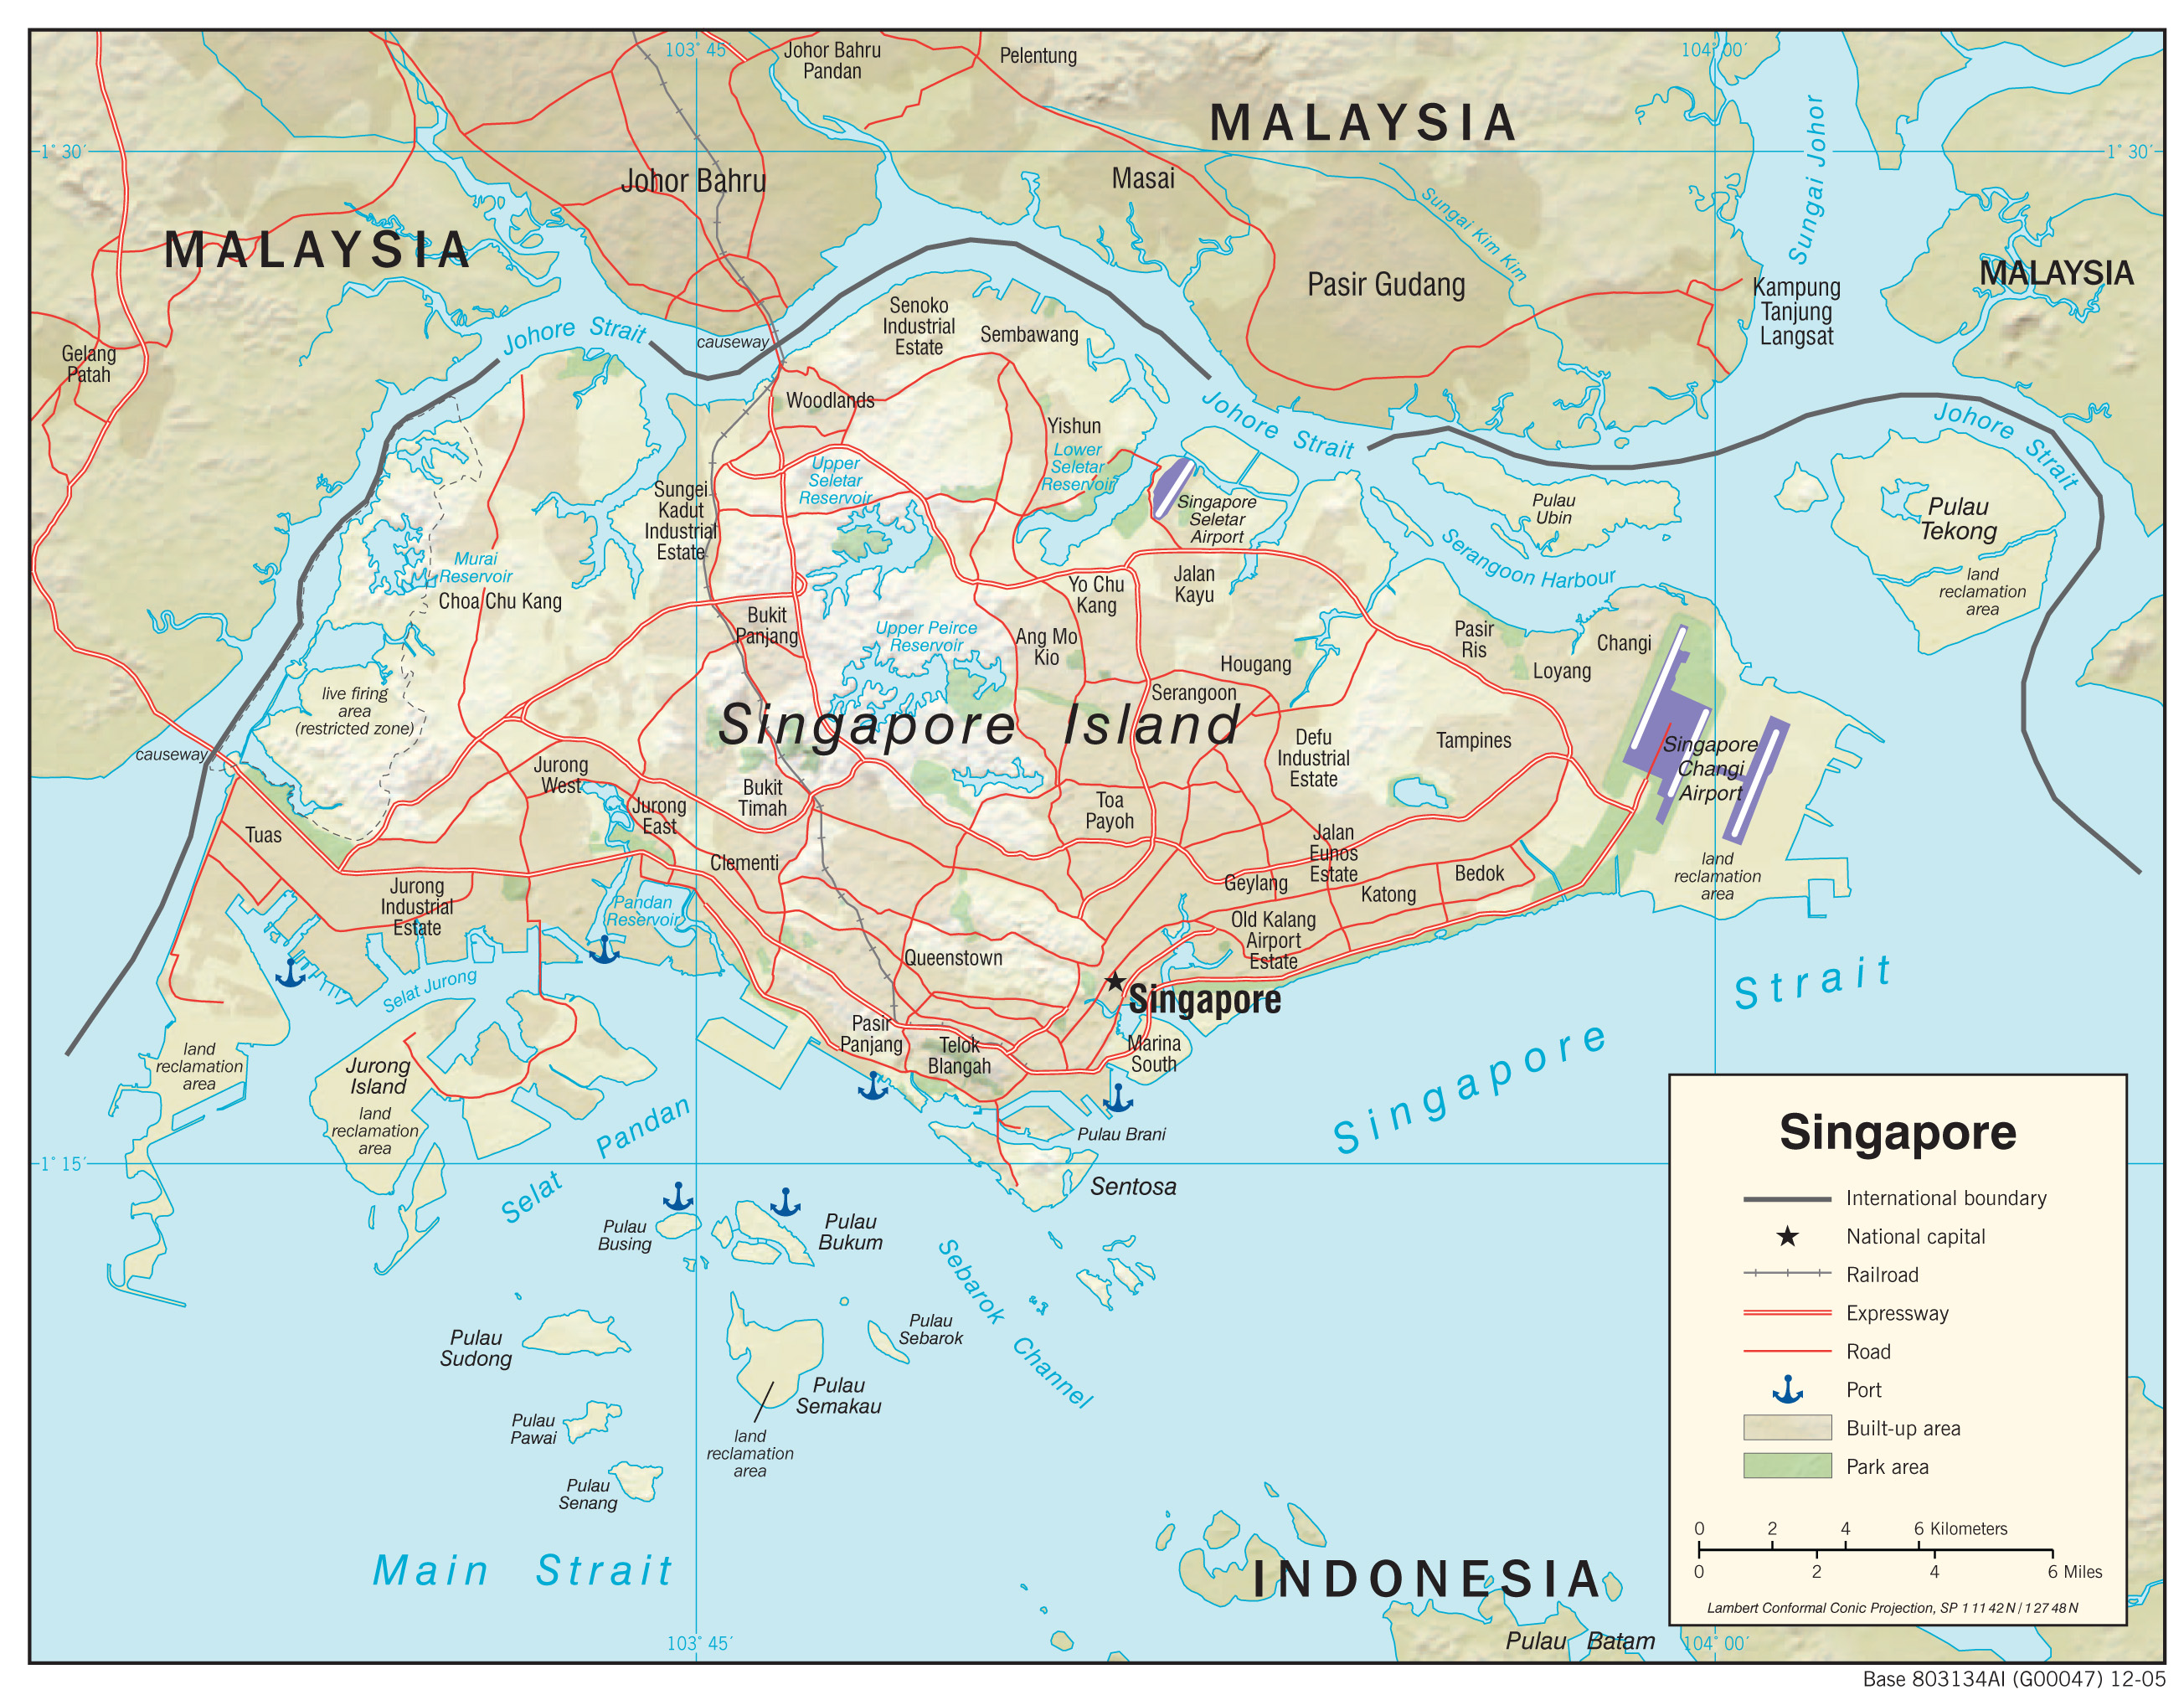

In [1]:
from IPython.display import Image
Image("https://www.lib.utexas.edu/maps/middle_east_and_asia/singapore_physio-2005.jpg", width ="600")

### Data Audit

As suggested by the project instruction, I've created a sample dataset to randomly check through for problematic data first.
This part also involces creating json files (a lot of code reuse from the previous MongoDB project) and loading them into a mongoDB database for further querying.
Based on the sample projects, a few key things to explore would be:
1. Incorrect postal code
1. Abbrevation used in the road names or building name
1. Inconsistencies on other part of the address

So let's begin checking on these three items and see what other issues I can find based on the Singapore sample dataset.

### Problems encountered in the Map

#### Incorrect postal code
``` javascript
{u'postcode': u'560564'}
{u'postcode': u'560573'}
{u'postcode': u'688688'}
{u'postcode': u'<different>'}
{u'postcode': u'81300'}
```

1. Postal codes - based on the sample dataset, most of the postal codes looks to be in the correct format which is a standard six digits format. 
    1. However there was something off found in the map with postal codes which are five digits long. 
    1. A check on the five digits postal codes shows that the node belongs to the neighbouring country of Malaysia.
    1. There's also one address which the postcode was keyed in as <different> rather than the standard six digits format. 
    
1. So those data with a none six digit postal codes can be removed from the map to avoid confusion.
    Hence we can probably remove that postal code so that the correct one can be inputted in the future.

### Problems encountered in the Map 2

#### Abbrevation used in the road names or building name

```javascript
{u'_id': u'Bukit Batok Street 32', u'count': 1}
{u'_id': u'Tanglin Road', u'count': 1}
{u'_id': u'Potong Pasir Avenue 1', u'count': 1}
{u'_id': u'Woodlands Drive 17', u'count': 1}
{u'_id': u'Upper Bukit Timah Road', u'count': 1}
{u'_id': u'Tanjong Pagar Road', u'count': 1}
```

1. Road names - the road names here doesn't show any issue of inconsistencies due the lack of of abbreviation usage. 
    1. A check through the common abbrevation found such as street, avenue, drive or road are fully spelled out in the street names.
    1. Hence no further work is required to clean this part up.


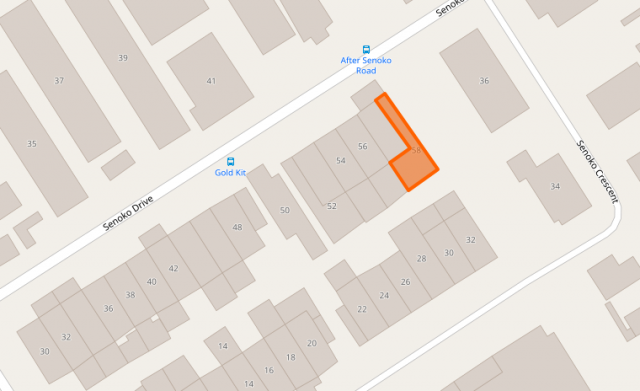

In [77]:
# https://www.openstreetmap.org/way/171633825
url = "https://preview.ibb.co/cUWtLb/Screen_Shot_2017_10_07_at_7_36_40_AM.png"

from IPython.display import Image
Image(url, width ="600")

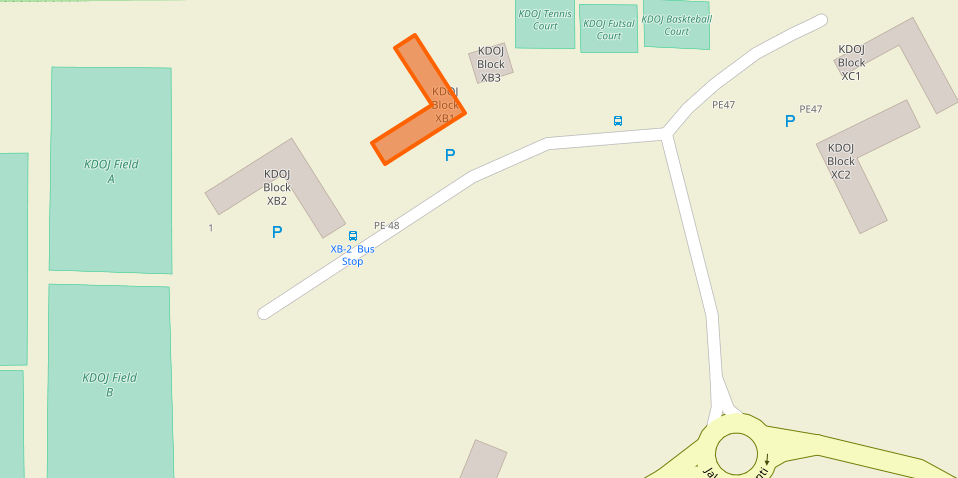

In [14]:
# https://www.openstreetmap.org/way/161046434
url = "https://image.ibb.co/mho9RG/Screen_Shot_2017_10_07_at_9_56_21_AM.png"

from IPython.display import Image
Image(url, width ="600")

### Problems encountered in the Map 3

#### Inconsistencies on other part of the address

``` javascript
{u'address': {u'housenumber': u'23',
              u'postcode': u'81300',
              u'street': u'Jalan Seri Impian 1, Taman Impian Emas,'}}
{u'address': {u'housename': u'Hilton Hotel Lobby'}}
{u'address': {u'street': u'Geylang East Avenue'}}
{u'address': {u'country': u'SG',
              u'housenumber': u'3',
              u'postcode': u'688688',
              u'street': u'Verde View'}}
{u'address': {u'housenumber': u'58'}}
{u'address': {u'housename': u'XB1'}}
```

1. Incomplete addresses - Certain way tags were used to label building but no address details were given, only house number or house name was given.
    1. Using the way id to check back on the OSM website, we can see that it's actually used to label building but the full address which includes the street name and postcode was not given. The house number 58 marks the building but there's no additional details such as postcode or street name was given.
    1. This issue also affects the map for the neighbouring country as can be seen on the way id 161046434. This present a new issue as without the postcode, we wouldn't be able to safely remove and keep only the addresses found in Singapore.

### Data Cleaning
So we've encountered two issues from checking the sample data set as follows:
1. Postal codes out of Singapore and incorrectly formatted postal codes.
1. Incomplete address.
    
#### Postal codes out of Singapore and incorrectly formatted postal codes

``` python
    sg_postcode_format = re.compile(r'^[0-9]{6}$')
    my_postcode_format = re.compile(r'^[0-9]{5}$')

    # remove the Malaysian cities information
    if (my_postcode_format.search(postcode)):
        data.remove(row)
    # remove postcode for cases like <different>
    elif not (sg_postcode_format.search(postcode)):
        del row["address"]["postcode"]
```

We will clean up the generated json and update them so that the final json input file which we will import into MongoDB will not contain any non Singapore address or those that contains invalid postal codes.

This can be done in two steps. On the first step we look for any address that contains a five digits postal codes and remove them from the data set.

And on the second step, we will check and only accept postal codes which are in the correct format. So for those postal codes which are not in the correct format, we will remove them for now because there's no easy solution to auto correct these values. A good example would be the postal code with the value &lt;different&gt; which we aren't able to auto fill the postal code value.

#### Incomplete address

As for this problem, I wasn't able to find a programmatic solution on how to map the node or way to a nearby entity to retrieve the street name or postcode.

According to the reference, the easiest way would be to have this information captured upon editing time. Otherwise the second best option would be to rely on the relations of type associated street to combine a street with the house numbers. Since this information is also not available in this dataset thus there's limited steps that we can take here.


### Data Analysis

So before running through some basic queries to check on the data set, let's look at the file size for the original osm file vs the generated json file.

```
singapore.osm 332.0 MB
singapore.osm2.json 469.0 MB
database size 451.5 MB
```

Based on the json file size generated, we can see that the file size have actually increased.
While the datasize after storing in the mongoDB is also quite close to the raw json file size.

Let's proceed to look at some other analysis.

#### Number of nodes and ways:

```
Number of documents: 2,041,233
Number of nodes: 1,814,515
Number of ways: 226,682
Number of unique users: 2,177
```

So there are over a total of 2 million documents in this dataset, and it's contributed by 2 thousand users. So that's an average of 1 thousand document created per user.

#### Top ten users that contributed the most:

```
{u'_id': u'JaLooNz', u'count': 432863}
{u'_id': u'cboothroyd', u'count': 119331}
{u'_id': u'berjaya', u'count': 103720}
{u'_id': u'rene78', u'count': 85319}
{u'_id': u'lmum', u'count': 51663}
{u'_id': u'singastreet', u'count': 47524}
{u'_id': u'kingrollo', u'count': 39036}
{u'_id': u'Luis36995', u'count': 38815}
{u'_id': u'ridixcr', u'count': 38711}
{u'_id': u'Sihabul Milah', u'count': 37305}
```

And out of the 2 million documents here, the top three user contributed over 600 thousand documents which are slightly below a third of the whole documents. The top user single handedly contributed over one fifth of the whole data set, that is pretty impressive contributions there.

#### Top ten street that appears the most in this data set:

```
{u'_id': u'Tamarind Road', u'count': 129}
{u'_id': u'Begonia Drive', u'count': 113}
{u'_id': u'Saraca Road', u'count': 106}
{u'_id': u'Kasai Road', u'count': 93}
{u'_id': u'Tanjong Pagar Road', u'count': 92}
{u'_id': u'Stratton Drive', u'count': 89}
{u'_id': u'Amoy Street', u'count': 84}
{u'_id': u'Neram Road', u'count': 82}
{u'_id': u'Bedok Reservoir Road', u'count': 74}
{u'_id': u'Mimosa Road', u'count': 64}
```

There appears to be three roads or drive that receives the most number of attention in this data set.

#### Top ten amenities that appeared the most in this data set:

```
{u'_id': u'restaurant', u'count': 2483}
{u'_id': u'parking', u'count': 2372}
{u'_id': u'place_of_worship', u'count': 1058}
{u'_id': u'atm', u'count': 826}
{u'_id': u'school', u'count': 756}
{u'_id': u'cafe', u'count': 614}
{u'_id': u'fast_food', u'count': 517}
{u'_id': u'fuel', u'count': 408}
{u'_id': u'taxi', u'count': 364}
{u'_id': u'bank', u'count': 363}
```

And in terms of amenities, the top three consists of restaurants, parking spots and place of worships. Good to know that we care the most about food, places to park our cars and being religious at the same time.

### Additional Analysis
Singapore is known for it's malls, hence it would be interesting to find out how many malls that we can find in this tiny little city that I call home.
So indeed, it's not bad that in this country, there's over 202 shoppings malls.
There's also shops that aren't properly labelled, with value set as yes instead of anything descriptive.

#### Finding the number of malls in Singapore

```
{u'_id': u'yes', u'count': 732}
{u'_id': u'convenience', u'count': 450}
{u'_id': u'supermarket', u'count': 422}
{u'_id': u'mall', u'count': 202}
{u'_id': u'clothes', u'count': 161}
{u'_id': u'beauty', u'count': 132}
{u'_id': u'bakery', u'count': 120}
{u'_id': u'furniture', u'count': 83}
{u'_id': u'car', u'count': 75}
{u'_id': u'hairdresser', u'count': 69}
```

So let's do a drill down to see what some of these shops which are tagged with the value yes to be.
Thus looking at the top ten in the list, there appears to be multiple items, ranging from None - unlabelled shops, to a mini mart, to a betting parlour, etc.

Thus much improvement can be done to properly clear up the shop label, but in order to do that we would need a a clean reference list on how to achieve this.


#### Finding out what shops are labeled with yes:
```
{u'_id': None, u'count': 15}
{u'_id': u'Minimart', u'count': 5}
{u'_id': u'Singapore Pools', u'count': 3}
{u'_id': u'Oppo', u'count': 3}
{u'_id': u'ABC', u'count': 3}
{u'_id': u'Jamal Kazura Aromatics', u'count': 2}
{u'_id': u'Swee Lee', u'count': 2}
{u'_id': u'Komala Vilas', u'count': 2}
{u'_id': u'Wonderful Gifts & Costume Jewellery', u'count': 2}
{u'_id': u'Ice Lab', u'count': 2}
```

#### Finding Bak Kut Teh (Local Speciality) Restaurants in Singapore
Singapore is known as the melting food of various cultures and with that comes really good local food, and one of the more popular ones is call Bak Kut Teh which basically means pork rib tea. It's actually a pork rib dish cooked in black pepper broth and served with rice.

I'm interested to check if I'm able to find the top 3 most popular Bak Kut Teh restaurants using OSM.And according to this blog, http://sethlui.com/best-bak-kut-teh-singapore/ the three most popular Bak Kut Teh here are Rong Hua, Legendary/Founder and Song Fa.

It will probably take a bit of trial and error to see what's the best way to identify these three restaurants using OSM. As there's no special tag to identify these restaurant, the most straight forward is probably to search using the name, but special care is given here to allow of different spelling of the Hokkien dish name.
Also matching using the amenity restaurant doesn't work, because some of these are categorised as shop.

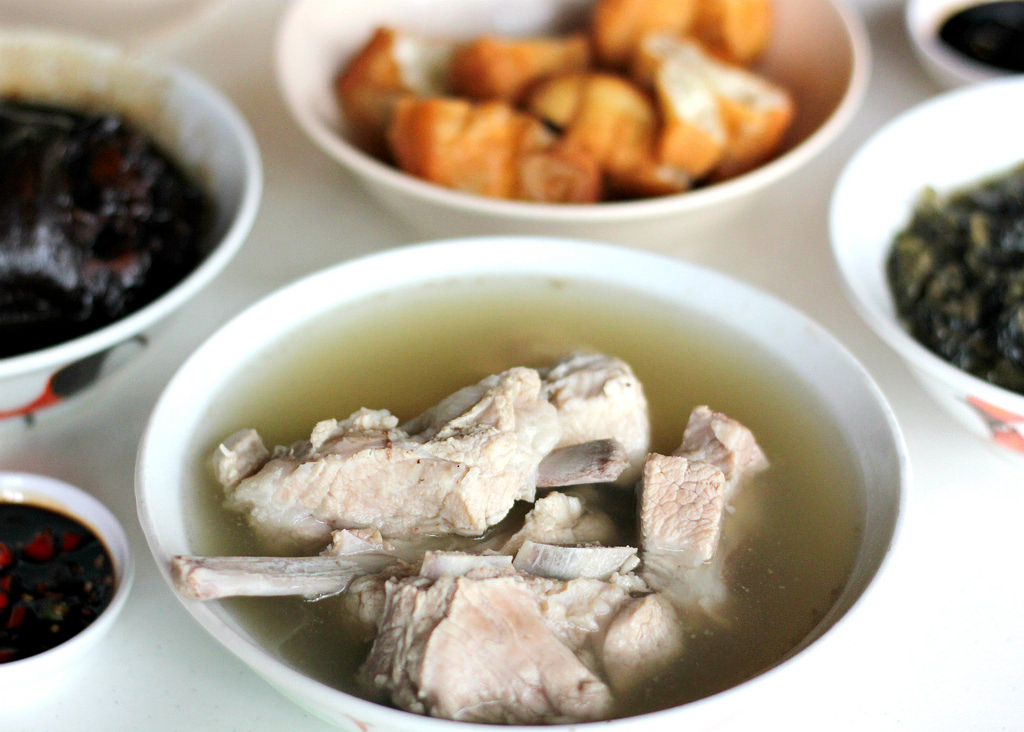

In [167]:
url = "https://c1.staticflickr.com/1/544/32474665746_0a98a1e883_b.jpg"

from IPython.display import Image
Image(url, width ="600")

#### Finding the top three bah kut teh restaurants in Singapore:

```
{u'_id': {u'zh': u'\u677e\u53d1\u8089\u9aa8\u8336'}, u'count': 2}
{u'_id': u'bak kut teh', u'count': 1}
{u'_id': u'Ya Hua Bah Kut Teh Eating House', u'count': 1}
{u'_id': u'Eunos (Mrt) Bak Koot Teh', u'count': 1}
{u'_id': u'Ah Tou Seafood Bok Kat Teh', u'count': 1}
{u'_id': u'Lau Rock Guan Kee Bak Kut Teh', u'count': 1}
{u'_id': u'Legendary Bak Kut Teh', u'count': 1}
{u'_id': u'Leong Kee Bak Kut Teh', u'count': 1}
{u'_id': u'Swis Ling Bak Kut Teh Seafood Restaurant', u'count': 1}
{u'_id': u'Shi Wah Bat Kut Teh', u'count': 1}
{u'_id': u'Rong Hua Bak Kut Teh', u'count': 1}
{u'_id': u'Soon Soon Heng Bak Kut Teh', u'count': 1}
{u'_id': u'Xin Mei Le Bak Kut Teh', u'count': 1}
{u'_id': u'Yong Bak Kut Teh', u'count': 1}
{u'_id': u'Ah Long Bak Kut Teh (\u70eb\u9c7c)', u'count': 1}
```

In [189]:
#### Checking the unicode / mandarin name for the bak kut teh restaurant 
print u'\u677e\u53d1\u8089\u9aa8\u8336'

松发肉骨茶


#### Findings Bak Kut Teh Conclusion
So it seems that the OSM data was maintained and was able to easily find the first two restaurants but had a bit of difficulty in finding the third one. It appears that the name was only captured in Unicode / Mandarin, 松发肉骨茶
, so I wasn't able to match it using the English name. But an additional attribute in the form of the website was given so I was still able to find it.

However on further checking across the website of each of the three restaurants above, we can see that the data may not be the latest. For example, we can see that there's two outlets already shown for Rong Hua Bak Kut Teh http://www.ronghua.com.sg/contact-us.html, but we're only able to get one address from the query.
This appears to be also the case for the Legendary/Founder Bak Kut Teh, http://legendarybkt.com/ where there are also two outlets listed on their website vs one address found on the OSM dataset. And finally a larger mismatch for the most popular Song Fa which already have seven outlets in Singapore, http://www.songfa.com.sg/outlets.html but we're only able to find two in the OSM dataset.


### Data Improvements
As this dataset consists of data from a neighbouring country, the first step of removing those nodes or ways by using the postal code format will work as a first layer. But we need additional help in identifying those nodes or ways in the dataset which are without the postal code format.

One cool improvement would be to have the OSM data entry page to allow for postal code auto street information look up, or any form of auto complete which could make the basic information such as street name or postal code to be populated upon entry, or include some basic validation to ensure basic fields are included to ensure that the data is more complete and easier to be use in query.

We saw that the house number 58 was entered by user JaLooNz which is also the top contributor which a record submission of 432,863 out of the total documents 2,041,233, that's around 20% of the dataset. And if this user tends to have a quick edit approach towards the data maintenace then that would largely affect the quality of the rest of the data set.

Another suggestion would be to have additional mobile app support which could allow the user to check into a particular location or start mapping upon app activation. Riding on the popularity of the app such as Pokemon Go, a simple app which allows the user to map a particular area and complete a goal, let's say a walking goal would be rather useful in allowing an accurate mapping of incomplete nodes or ways. The check in feature can also be useful in identifying point of interests, or restaurants which can lead to be more quality data set. 

Due to the more complicated nature of searching names using unicode in MongoDB instead of plain English, I would also like to suggest that perhaps the English name would be needed by default and allow the Unicode version of the name to included as a secondary name.

### Appendix

#### Additional Problems encountered with MongoDB setup
However an unexpected problem occured when I had difficulty trying to import the original osm file into the mongodb.

1. Mongoimport unable to import the whole osm file and encountered error along the way.
1. I was using conda environment mongodb version 3.3.9 and wasn't able to import even after reinstalling the mongodb a few times.
1. Next attempt is to run the mongodb via homebrew to see if that will help with the situation.

#### Resolution
So the issue is apparently on that particular version of mongodb + Mac OS Sierra, after I've installed the conda version of 3.3.9 and use the homebrew installed version of 3.4.9 to run the mongoimport, things were working just nicely.


#### References:
1. https://review.udacity.com/#!/rubrics/25/view
1. https://docs.google.com/document/d/1F0Vs14oNEs2idFJR3C_OPxwS6L0HPliOii-QpbmrMo4/pub
1. https://gist.github.com/carlward/54ec1c91b62a5f911c42#file-sample_project-md
1. https://www.youtube.com/watch?v=d6n29CU2-Sg
1. https://www.openstreetmap.org/welcome
1. https://github.com/jasonicarter/DAND_OpenStreetMap_Data_MongoDB/blob/master/OpenStreetMap_Data_MongoDB.ipynb
1. https://gis.stackexchange.com/questions/171149/link-between-node-building-street-in-osm
1. https://stackoverflow.com/questions/2896752/removing-item-from-list-during-iteration-whats-wrong-with-this-idiom
1. https://code.activestate.com/recipes/577081-humanized-representation-of-a-number-of-bytes/
1. http://sethlui.com/best-bak-kut-teh-singapore/

#### Source Codes
1. create_samplefile.py - To generate the sample osm for the initial data audit.
1. create_mongodb_json.py - To extract the data from the osm file into mongodb compatible json input file.
1. load_database_cmd - mongoimport command to import the sample osm json and the singapore osm json file.
1. data_audit.py - queries to check through and identify the issues found in the sample dataset.
1. data_cleaning.py - code to clean the dataset based on the identified problems.
1. data_analysis.py - code to analyse the dataset.